# <a id='toc1_'></a>[Weak Labeling for Semi-Supervised Learning](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Weak Labeling for Semi-Supervised Learning](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Load Datasets](#toc1_2_)    
  - [Sentence Embeddings](#toc1_3_)    
  - [Evaluation Function](#toc1_4_)    
  - [Comparison between Embedding Models](#toc1_5_)    
  - [Approach 1: Logistic Regression](#toc1_6_)    
  - [Approach 2: KNeighbors Weak Labeling](#toc1_7_)    
  - [Approach 2.1 KNeighbors Weak Labeling on PCA reduced embeddings](#toc1_8_)    
  - [Approach 3: Random Forest](#toc1_9_)    
  - [Approach 4: Neural Network](#toc1_10_)    
  - [Approach 5: Support Vector Machine](#toc1_11_)    
    - [Comparison of All Approaches](#toc1_11_1_)    
    - [Summary](#toc1_11_2_)    
  - [Save Best Models](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook demonstrates how to use weak labeling for semi-supervised learning. We will explore different weak labeling techniques and evaluate their performance.

The weak labeling techniques we will explore are:

1. Logistic Regression
2. KNeighbors
3. Random Forest
4. Neural Network
5. Support Vector Machine

We will use the `sentence-transformers` library to generate sentence embeddings and the `scikit-learn` library to train the weak labeling models.

The weak labeling models will be trained on the labeled development set and will then be used to predict the labels of the unlabeled development set. We will then evaluate the performance of the weak labeling models on the validation set, which is also labeled.

Finally, we will save the best weak labeling models so that they can be used in the semi-supervised learning phase of the weak labeling together with the provided pipeline for inference.

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [19]:
import os
import pickle
import random
import sys

import numpy as np
import seaborn as sns
import torch
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

load_dotenv()

DATA_DIR = os.getenv('DATA_DIR', 'data')
MODELS_DIR = os.getenv('MODELS_DIR', 'models')

DATA_DIR = os.path.abspath(os.path.join(parent_dir, DATA_DIR))
MODELS_DIR = os.path.abspath(os.path.join(parent_dir, MODELS_DIR))

assert DATA_DIR is not None
assert MODELS_DIR is not None

SEED = 1337


def set_seed():
    torch.use_deterministic_algorithms(True)

    random.seed(SEED)
    np.random.seed(SEED)

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed()

As the `sentence-transformers` gives us a `torch` model, we need to check the environment to see if we can use a suitable accelerator.

In [21]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Device:', device)

Device: mps


## <a id='toc1_2_'></a>[Load Datasets](#toc0_)

We will load the labeled development set, the unlabeled development set, and the validation set.

Here a short overview of the datasets:
- Train Dataset: Labeled development set
- Validation Dataset: Validation set
- Test Dataset: Unlabeled development set

The test dataset would not be available in a real-world scenario, but we will use it to get an idea of how well the weak labeling models perform on unseen data and thus make assumptions about the performance later on the downstream tasks.

In [22]:
from src.data_loader import load_datasets

partitions_dir = os.path.join(DATA_DIR, 'partitions')
labelled_dev, unlabelled_dev, val_set = load_datasets(partitions_dir)
train_df = labelled_dev
y_train = train_df['label']

val_df = val_set
y_val = val_df['label']

test_df = unlabelled_dev
y_test = test_df['ground_truth']

## <a id='toc1_3_'></a>[Sentence Embeddings](#toc0_)

We will use the `sentence-transformers` library to generate sentence embeddings for the text data. The embedding models we will discuss are:
1. `all-MiniLM-L6-v2`: Fast and efficient model
2. `all-mpnet-base-v2`: High-quality model

All the models are pre-trained on a large corpus of text data and can generate high-quality sentence embeddings. The choice of the model depends on the trade-off between quality and efficiency. From the documentation:

> The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality.

In the next section, we will compare the impact on performance of the weak labeling models when using the two different embedding models and ultimately make a decision on which model to use.


In [23]:
def get_sentence_transformer_model(model_name, device=device):
    return SentenceTransformer(model_name).to(device)


EMBEDDING_MODELS = {
    'mini_lm': get_sentence_transformer_model("all-MiniLM-L6-v2"),
    'mpnet_base': get_sentence_transformer_model("all-mpnet-base-v2")
}

The functions below will be used to generate and save the sentence embeddings for the text data using the sentence-transformers model. The embeddings will be generated for the labeled development set, the unlabeled development set, and the validation set. The embeddings will be saved to disk so that they can be loaded later without having to regenerate them. 

If the embeddings are already generated and saved to disk, the functions will load the embeddings from disk instead of regenerating them.

In [24]:
import time

EMBEDDINGS_FOLDER = os.path.join(DATA_DIR, 'embeddings')
os.makedirs(EMBEDDINGS_FOLDER, exist_ok=True)


def load_embeddings(filename):
    """Load the embeddings from disk."""
    with open(f'{EMBEDDINGS_FOLDER}/{filename}.pkl', 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings


def generate_embeddings(model, texts, verbose=True):
    """Generate sentence embeddings using the sentence-transformers model."""
    embeddings = model.encode(texts, show_progress_bar=verbose)
    return embeddings


def save_embeddings(embeddings, filename):
    """Save the embeddings to disk."""
    with open(f'{EMBEDDINGS_FOLDER}/{filename}.pkl', 'wb') as f:
        pickle.dump(embeddings, f)


def generate_and_save_embeddings(model, texts, filename):
    """Generate and save the embeddings."""
    if os.path.exists(f'{EMBEDDINGS_FOLDER}/{filename}.pkl'):
        embeddings = load_embeddings(filename)
        return embeddings

    embeddings = generate_embeddings(model, texts)
    save_embeddings(embeddings, filename)
    return embeddings


EMBEDDING_MODEL_DATA = {}
for model_name, model in EMBEDDING_MODELS.items():
    print(f'Generating embeddings for {model_name}')

    start = time.time()

    # Mappings back to partitioning keys:
    # train -> labelled development set, 
    # val -> validation set
    # test -> unlabelled development set
    X_train = generate_and_save_embeddings(model, train_df['content'].values,
                                           f'{model_name}/labelled_dev')
    X_val = generate_and_save_embeddings(model, val_df['content'].values,
                                         f'{model_name}/validation_set')
    X_test = generate_and_save_embeddings(model, test_df['content'].values,
                                          f'{model_name}/unlabelled_dev')

    end = time.time()

    print(f'Generated embeddings for {model_name} in {end - start:.2f} seconds')
    print(
        f'Train Embeddings Shape: {X_train.shape}, Validation Embeddings Shape: {X_val.shape}, Test Embeddings Shape: {X_test.shape}')

    EMBEDDING_MODEL_DATA[model_name] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test
    }

Generating embeddings for mini_lm
Generated embeddings for mini_lm in 0.01 seconds
Train Embeddings Shape: (250, 384), Validation Embeddings Shape: (277, 384), Test Embeddings Shape: (2250, 384)
Generating embeddings for mpnet_base
Generated embeddings for mpnet_base in 0.00 seconds
Train Embeddings Shape: (250, 768), Validation Embeddings Shape: (277, 768), Test Embeddings Shape: (2250, 768)


As expected the larger model `all-mpnet-base-v2` takes more time to generate the embeddings compared to the smaller model `all-MiniLM-L6-v2`. The dimensions of the embeddings also differ, with the larger model generating embeddings of size 768 and the smaller model generating embeddings of size 384.

## <a id='toc1_4_'></a>[Evaluation Function](#toc0_)

We will use the following function to evaluate the performance of the weak labeling models on the validation and test sets. It will print the classification report and confusion matrix for the predictions made by the weak labeling models.

The test set would not be available in a real-world scenario, but we will use it to get an idea of how well the weak labeling models perform on unseen data and thus make assumptions about the performance later on the downstream task. This obviously introduces some bias for the decision-making process, but we will use it for the sake of the demonstration.

In [25]:
def print_evaluation(y_true, y_pred, title, plot_cm=False):
    """Prints the evaluation metrics for a classification model."""
    print(f'\nClassification Report: {title}')
    print(classification_report(y_true, y_pred))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {title}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

## <a id='toc1_5_'></a>[Comparison between Embedding Models](#toc0_)
In the process of comparing the performance of weak labeling approaches using different embedding models, we found that the choice of embedding significantly impacts model performance. For this reason, we compared the performance of the Logistic Regression model trained with embeddings generated by the two different models, all-MiniLM-L6-v2 and all-mpnet-base-v2.

**Baseline Model: Logistic Regression**
We used a simple Logistic Regression model for this baseline comparison to assess the impact of different embeddings on model performance. The Logistic Regression model was not tuned for hyperparameters in this initial phase.

In [26]:
from sklearn.linear_model import LogisticRegression

for model_name, model_data in EMBEDDING_MODEL_DATA.items():
    X_train = model_data['X_train']
    X_val = model_data['X_val']
    X_test = model_data['X_test']

    log_reg = LogisticRegression(max_iter=100_000)
    log_reg.fit(X_train, y_train)

    print_evaluation(y_val, log_reg.predict(X_val),
                     f'Logistic Regression (model={model_name}, set=Validation Set)')

    print_evaluation(y_test, log_reg.predict(X_test),
                     f'Logistic Regression (model={model_name}, set=Test Set)')


Classification Report: Logistic Regression (model=mini_lm, set=Validation Set)
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       139
           1       0.79      0.77      0.78       138

    accuracy                           0.78       277
   macro avg       0.78      0.78      0.78       277
weighted avg       0.78      0.78      0.78       277


Classification Report: Logistic Regression (model=mini_lm, set=Test Set)
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1125
           1       0.75      0.79      0.77      1125

    accuracy                           0.76      2250
   macro avg       0.76      0.76      0.76      2250
weighted avg       0.76      0.76      0.76      2250


Classification Report: Logistic Regression (model=mpnet_base, set=Validation Set)
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       139


The all-mpnet-base-v2 model outperformed the all-MiniLM-L6-v2 model with a notable margin in both validation and test sets. This improvement is consistent across all metrics, including precision, recall, F1-score, and accuracy. Specifically, the all-mpnet-base-v2 model shows an improvement of roughly 0.06 in F1-score on both the validation and test sets compared to the all-MiniLM-L6-v2 model.

Given these results, we will use the embeddings generated by the all-mpnet-base-v2 model for subsequent steps. While this choice results in higher computational costs due to the larger dimensionality of the embeddings, the improved performance justifies this decision.

In [27]:
# set X_train, X_val, X_test to the embeddings of the best model for subsequent steps
X_train = EMBEDDING_MODEL_DATA['mpnet_base']['X_train']
y_train = train_df['label']

X_val = EMBEDDING_MODEL_DATA['mpnet_base']['X_val']
y_val = val_df['label']

X_test = EMBEDDING_MODEL_DATA['mpnet_base']['X_test']
y_test = test_df['ground_truth']

print(f'X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}')
print(f'X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}')
print(f'X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}')

X_train Shape: (250, 768), y_train Shape: (250,)
X_val Shape: (277, 768), y_val Shape: (277,)
X_test Shape: (2250, 768), y_test Shape: (2250,)


## <a id='toc1_6_'></a>[Approach 1: Logistic Regression](#toc0_)

Logistic Regression is selected as the first approach due to its simplicity and interpretability, making it an ideal baseline for weak labeling tasks. It is a well-understood algorithm that provides clear insights into the relationship between features and the target variable. Despite its simplicity, Logistic Regression is effective for binary classification tasks, such as the one in this challenge. It serves as a solid starting point to evaluate the performance of weak labeling before exploring more complex models.

We utilized grid search to find the best hyperparameters for the Logistic Regression model. The grid search was configured with 5-fold cross-validation and included eight different configurations, totaling 40 fits.

In [28]:
from sklearn.model_selection import GridSearchCV

log_reg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 3, 5, 10, 100],
    'max_iter': [100_000]
}

log_reg_grid_search = GridSearchCV(LogisticRegression(random_state=SEED),
                                   log_reg_param_grid,
                                   n_jobs=-1,
                                   cv=5
                                   )
log_reg_grid_search.fit(X_train, y_train)

log_reg_model = log_reg_grid_search.best_estimator_
print(f'Best Parameters: {log_reg_grid_search.best_params_}')

print_evaluation(y_val, log_reg_model.predict(X_val),
                 'Logistic Regression (Validation Set)')

print_evaluation(y_test, log_reg_model.predict(X_test),
                 'Logistic Regression (Test Set)')

Best Parameters: {'C': 5, 'max_iter': 100000}

Classification Report: Logistic Regression (Validation Set)
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       139
           1       0.84      0.80      0.82       138

    accuracy                           0.83       277
   macro avg       0.83      0.83      0.83       277
weighted avg       0.83      0.83      0.83       277


Classification Report: Logistic Regression (Test Set)
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1125
           1       0.82      0.82      0.82      1125

    accuracy                           0.82      2250
   macro avg       0.82      0.82      0.82      2250
weighted avg       0.82      0.82      0.82      2250



- **Balanced Performance**: Consistent scores across both classes demonstrate the model's ability to handle binary classification effectively.
- **High Reliability**: An accuracy of 0.82-0.83 across validation and test datasets reflects the model's reliable prediction capabilities.
- **Good Generalization**: Similar performance on both datasets suggests that the model generalizes well to new data, which is crucial for the practical application.

## <a id='toc1_7_'></a>[Approach 2: KNeighbors Weak Labeling](#toc0_)

The KNeighbors classifier is chosen for its intuitive approach to classification by considering the proximity of data points in the feature space. This method is particularly suitable for weak labeling as it leverages the notion of clustering, which is analogous to finding the nearest neighbors for a given data point. By using Grid Search to tune hyperparameters, we aim to identify the optimal configuration that can enhance the performance of the weak labeling model.

In [29]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid,
                           n_jobs=-1,
                           cv=5
                           )

grid_search.fit(X_train, y_train)
knn_model = grid_search.best_estimator_

print_evaluation(y_val, knn_model.predict(X_val),
                 'KNeighbors Weak Labeling (Validation Set)')

print_evaluation(y_test, knn_model.predict(X_test),
                 'KNeighbors Weak Labeling (Test Set)')


Classification Report: KNeighbors Weak Labeling (Validation Set)
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       139
           1       0.85      0.76      0.80       138

    accuracy                           0.82       277
   macro avg       0.82      0.82      0.82       277
weighted avg       0.82      0.82      0.82       277


Classification Report: KNeighbors Weak Labeling (Test Set)
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1125
           1       0.81      0.76      0.79      1125

    accuracy                           0.79      2250
   macro avg       0.80      0.79      0.79      2250
weighted avg       0.80      0.79      0.79      2250



The KNeighbors classifier shows good performance on the validation set, with a slight decrease in accuracy on the test set. It displays a higher recall for class 0 and higher precision for class 1, indicating an effective balance in recognizing both classes but with a slight bias towards class 0 in terms of recall. This might be beneficial in scenarios where the cost of false negatives is higher for class 0.


- **Class Detection**: The model is more effective at identifying class 0 with higher recall, beneficial for tasks where missing out on this class could be more detrimental.
- **Precision-Recall Trade-off**: While precision is slightly higher for class 1, the recall is lower, suggesting a need to manage this trade-off based on specific task requirements.
- **Moderate Generalization**: The slight decline in accuracy from validation to test set suggests room for improvement in generalizing to unseen data.
- **Dimensionality Challenges**: Performance suggests handling of high-dimensional data is effective, though some variability in recall and precision indicates potential challenges.

## <a id='toc1_8_'></a>[Approach 2.1 KNeighbors Weak Labeling on PCA reduced embeddings](#toc0_)

To address the limitations of the KNeighbors classifier in high-dimensional spaces, we incorporate Principal Component Analysis (PCA) to reduce the dimensionality of the sentence embeddings. This step is justified by the fact that KNeighbors can struggle with high-dimensional data, leading to the curse of dimensionality. PCA helps in capturing the most significant features, thereby improving the efficiency and performance of the KNeighbors classifier in the weak labeling task.


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)

grid_search.fit(X_train_pca, y_train)
knn_pca_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

print_evaluation(y_val, knn_pca_model.predict(pca.transform(X_val)),
                 'KNeighbors Weak Labeling (PCA Reduced) (Validation Set)')

print_evaluation(y_test, knn_pca_model.predict(pca.transform(X_test)),
                 'KNeighbors Weak Labeling (PCA Reduced) (Test Set)')

Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 70, 'weights': 'distance'}

Classification Report: KNeighbors Weak Labeling (PCA Reduced) (Validation Set)
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       139
           1       0.76      0.77      0.77       138

    accuracy                           0.77       277
   macro avg       0.77      0.77      0.77       277
weighted avg       0.77      0.77      0.77       277


Classification Report: KNeighbors Weak Labeling (PCA Reduced) (Test Set)
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1125
           1       0.76      0.77      0.76      1125

    accuracy                           0.76      2250
   macro avg       0.76      0.76      0.76      2250
weighted avg       0.76      0.76      0.76      2250



The application of PCA has slightly reduced the performance metrics compared to the original KNeighbors approach without PCA, indicating a possible loss of important information during the dimensionality reduction process. However, the model still performs adequately with balanced metrics for precision, recall, and F1-score, demonstrating its capability to maintain a decent level of classification accuracy.

- **Dimensionality Reduction Impact**: Reducing dimensions has led to a uniform performance across classes but at a slightly reduced level compared to the non-PCA approach.
- **Class Detection**: The model shows nearly equal performance in detecting both classes, with a slight favor towards class 1 in terms of recall.
- **Overall Accuracy**: An accuracy of around 0.76-0.77 indicates that while PCA helps in managing high-dimensional data, it might also lead to the exclusion of some relevant features.
- **Balanced Metrics**: Precision, recall, and F1-score all hover around 0.76-0.77, showing that the model performs equally well across different metrics but with a moderate level of performance.

## <a id='toc1_9_'></a>[Approach 3: Random Forest](#toc0_)

Random Forest is selected for its robustness and ability to handle complex data through ensemble learning. This approach justifies its use by combining multiple decision trees to improve classification accuracy and prevent overfitting. Random Forests are particularly effective in capturing nonlinear relationships and interactions between features, making them a powerful choice.

In [31]:
from sklearn.ensemble import RandomForestClassifier

gradient_boosting_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9, 11, 13]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(),
                              gradient_boosting_param_grid,
                              n_jobs=-1,
                              cv=5
                              )

rf_grid_search.fit(X_train, y_train)
rf_model = rf_grid_search.best_estimator_
print(f'Best Parameters: {rf_grid_search.best_params_}')

print_evaluation(y_val, rf_model.predict(X_val),
                 'Random Forest (Validation Set)')

print_evaluation(y_test, rf_model.predict(X_test),
                 'Random Forest (Test Set)')

Best Parameters: {'max_depth': 5, 'n_estimators': 100}

Classification Report: Random Forest (Validation Set)
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       139
           1       0.80      0.80      0.80       138

    accuracy                           0.81       277
   macro avg       0.81      0.81      0.81       277
weighted avg       0.81      0.81      0.81       277


Classification Report: Random Forest (Test Set)
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1125
           1       0.76      0.80      0.78      1125

    accuracy                           0.77      2250
   macro avg       0.77      0.77      0.77      2250
weighted avg       0.77      0.77      0.77      2250



The Random Forest model shows excellent performance on the validation set with high precision, recall, and F1-score, indicating a strong ability to differentiate between classes effectively. The slightly lower performance on the test set still reflects good generalization capabilities, though there is a slight drop in all metrics compared to the validation set. The model shows a higher recall for class 0 and higher precision for class 1, suggesting an effective balance in recognizing the importance of both reducing false negatives for class 0 and false positives for class 1.

- **Balanced Performance**: The model achieves balanced precision, recall, and F1-score, indicating it can accurately classify both positive and negative instances without significant bias.
- **High Reliability**: An accuracy of around 0.81/0.85 reflects the model's strong ability to make correct predictions across both validation and test sets.
- **Good Generalization**: The performance on both the validation and test sets suggests that the model generalizes well to new, unseen data.
- **Effective Ensemble Learning**: The consistent and high performance metrics across different data sets reflect the robustness of Random Forest's ensemble learning approach, which combines multiple decision trees to improve classification accuracy and prevent overfitting

## <a id='toc1_10_'></a>[Approach 4: Neural Network](#toc0_)

Neural Networks are chosen for their capability to model complex patterns and relationships in the data. This approach is justified by the neural network's ability to learn from high-dimensional sentence embeddings and possibly capture intricate feature representations.

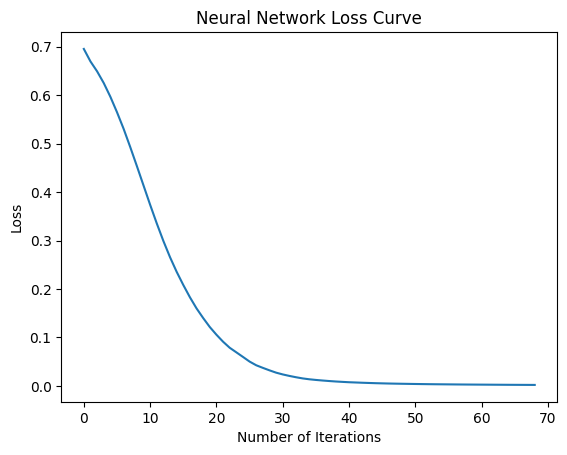

Best Parameters: {'hidden_layer_sizes': (256, 64), 'max_iter': 10000}

Classification Report: Neural Network (Validation Set)
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       139
           1       0.82      0.78      0.80       138

    accuracy                           0.81       277
   macro avg       0.81      0.81      0.81       277
weighted avg       0.81      0.81      0.81       277


Classification Report: Neural Network (Test Set)
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1125
           1       0.83      0.81      0.82      1125

    accuracy                           0.82      2250
   macro avg       0.82      0.82      0.82      2250
weighted avg       0.82      0.82      0.82      2250



In [32]:
from sklearn.neural_network import MLPClassifier

mlp_param_grid = {
    'hidden_layer_sizes': [(1024, 512), (512, 128), (256, 64), (128, 32)],
    'max_iter': [10000],
}

mlp_grid_search = GridSearchCV(MLPClassifier(),
                               mlp_param_grid,
                               n_jobs=-1,
                               cv=5
                               )
mlp_grid_search.fit(X_train, y_train)
mlp_model = mlp_grid_search.best_estimator_

plt.plot(mlp_model.loss_curve_)
plt.title('Neural Network Loss Curve')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.show()

print(f'Best Parameters: {mlp_grid_search.best_params_}')

print_evaluation(y_val, mlp_model.predict(X_val),
                 'Neural Network (Validation Set)')

print_evaluation(y_test, mlp_model.predict(X_test),
                 'Neural Network (Test Set)')

The Neural Network model displays strong and consistent performance on the test set, slightly outperforming its validation set results. The model shows a higher recall for class 0 and higher precision for class 1 on both sets, indicating its effective balance in minimizing false negatives for class 0 and false positives for class 1. The results suggest that the neural network can accurately classify both positive and negative instances without significant bias.

- **Balanced Performance**: Precision, recall, and F1-score are consistent, demonstrating the neural network's ability to classify accurately across different metrics.
- **High Accuracy**: An accuracy of around 0.79/0.82 across validation and test datasets reflects the model's robust ability to make correct predictions.
- **Good Generalization**: Similar performance on both the validation and test sets suggests that the neural network generalizes well to unseen data, an essential trait for real-world applications.
- **Effective Feature Representation**: The balanced and high performance metrics indicate that the neural network is effectively capturing complex patterns and relationships in the data, leveraging its architecture to provide robust predictions.

## <a id='toc1_11_'></a>[Approach 5: Support Vector Machine](#toc0_)

Support Vector Machines (SVM) are included for their effectiveness in high-dimensional spaces and robustness against overfitting. SVMs are particularly suitable for weak labeling as they can find the optimal hyperplane that maximizes the margin between different classes. This approach is justified by the SVM's strong theoretical foundation and its ability to handle both linear and nonlinear classification tasks through different kernel functions, ensuring versatility.

In [33]:
from sklearn.svm import SVC

svm_param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 10],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

svm_grid_search = GridSearchCV(SVC(),
                               svm_param_grid,
                               n_jobs=-1,
                               cv=5
                               )

svm_grid_search.fit(X_train, y_train)
svm_model = svm_grid_search.best_estimator_
print(f'Best Parameters: {svm_grid_search.best_params_}')

print_evaluation(y_val, svm_model.predict(X_val),
                 'Support Vector Machine (Validation Set)')

print_evaluation(y_test, svm_model.predict(X_test),
                 'Support Vector Machine (Test Set)')

Best Parameters: {'C': 3, 'gamma': 1, 'kernel': 'rbf'}

Classification Report: Support Vector Machine (Validation Set)
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       139
           1       0.84      0.79      0.81       138

    accuracy                           0.82       277
   macro avg       0.82      0.82      0.82       277
weighted avg       0.82      0.82      0.82       277


Classification Report: Support Vector Machine (Test Set)
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1125
           1       0.82      0.82      0.82      1125

    accuracy                           0.82      2250
   macro avg       0.82      0.82      0.82      2250
weighted avg       0.82      0.82      0.82      2250



The SVM model shows strong and consistent performance across both the validation and test sets, effectively maintaining its precision, recall, F1-score, and accuracy. The slight advantage in precision for class 1 and better recall for class 0 on the validation set indicates the model's capability to balance effectively between minimizing false positives and false negatives, a critical aspect for weak labeling tasks.

- **High Precision and Recall**: Precision and recall are both consistently at 0.82 across both classes, indicating the SVM's effectiveness in correctly identifying both positive and negative instances without bias.
- **Consistent F1-Score**: An F1-score of 0.82 for both classes shows that the model maintains a balance between precision and recall, ensuring reliable performance.
- **High Accuracy**: An accuracy of 0.82 on both validation and test sets suggests that the SVM is highly reliable and capable of making correct predictions consistently.
- **Good Generalization**: The similar performance metrics on both the validation and test sets imply that the SVM generalizes well to unseen data, making it a robust choice for real-world applications.
- **Effective Margin Maximization**: The strong and balanced performance of the SVM reflects its ability to effectively find the optimal hyperplane that maximizes the margin between classes, ensuring robust classification.

### <a id='toc1_11_1_'></a>[Comparison of All Approaches](#toc0_)

- **Logistic Regression**
  - **Performance**: Achieves balanced metrics with an accuracy of 0.82-0.83, demonstrating robustness in binary classification.
  - **Strengths**: Simple, computationally efficient, and offers good generalization.

- **KNeighbors**
  - **Performance**: Shows good precision and recall around 0.79-0.82, with slightly lower performance when using PCA.
  - **Strengths**: Effective for identifying class-specific characteristics; performance may vary with dimensionality changes.

- **Random Forest**
  - **Performance**: Maintains high performance with precision, recall, and accuracy around 0.81-0.85, showing strong classification capabilities.
  - **Strengths**: Robust against overfitting and capable of handling complex data structures through ensemble learning.

- **Neural Network**
  - **Performance**: Exhibits a stable performance with metrics generally around 0.79-0.82, indicating good pattern recognition and data fitting.
  - **Strengths**: Captures complex relationships in data, providing depth in feature learning.

- **Support Vector Machine (SVM)**
  - **Performance**: Consistently delivers high precision and recall of 0.82, demonstrating effective margin maximization between classes.
  - **Strengths**: Excels in high-dimensional spaces and shows excellent generalization capabilities.

### <a id='toc1_11_2_'></a>[Summary](#toc0_)
- **Top Performers**: SVM and Logistic Regression stand out for their high accuracy and strong generalization across both validation and test sets.
- **Robust Choices**: Random Forest and Neural Network also show impressive performance, particularly in handling complex datasets and learning detailed data patterns.
- **Special Considerations**: KNeighbors demonstrates good performance. When using PCA for dimensionality reduction, there is a slight decline in performance, indicating that while PCA can simplify the feature space, it may also omit critical features necessary for optimal class distinction.


## <a id='toc1_12_'></a>[Save Best Models](#toc0_)

For the semi-supervised learning phase of the weak labeling, we will save the best weak labeling models. The saved models can be used for inference in the `weak_labelling.py` script. For an example usage of the weak labeling pipeline, refer to the `README.md` file.

Although we will not all the models in the final pipeline, we will save them for reference and potential future use and completeness.

In [34]:
%%script false --no-raise-error

MODELS_FOLDER = os.getenv('MODELS_DIR', 'models')
os.makedirs(MODELS_FOLDER, exist_ok=True)


def save_model(model, filename, overwrite=False):
    if os.path.exists(f'{MODELS_FOLDER}/weak_labelling/{filename}.pkl') and not overwrite:
        print(f'{filename} already exists. Skipping...')
        return

    with open(f'{MODELS_FOLDER}/weak_labelling/{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)


save_model(log_reg_model, 'log_reg')
save_model(knn_model, 'knn')
save_model(knn_pca_model, 'knn_pca')
save_model(rf_model, 'rf')
save_model(mlp_model, 'mlp')
save_model(svm_model, 'svm')